In [1]:
import numpy as np
import pandas as pd
import time
import sys
import os

sys.path.append("../")

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

os.environ["OMP_NUM_THREADS"] = "2"

In [3]:
def preprocessing():
    dataset = pd.read_csv("./data/german_credit_data.csv").drop("Unnamed: 0", axis=1)

    dataset.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

    for column in dataset.columns:
        if dataset[column].dtype != np.dtype("int64"):
            dataset[column] = LabelEncoder().fit_transform(dataset[column])

    return dataset


def train_model(x, y, model):
    cv = KFold(n_splits=3, random_state=None)
    global total_cm
    total_cm = np.zeros((2, 2))
    metric_dict = {}
    split_dict = {}

    it = 0
    for train_ind, test_ind in cv.split(x):
        x_train, x_test = x[train_ind], x[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        total_cm += confusion_matrix(y_test, y_pred)

        metrics = [
            accuracy_score(y_test, y_pred) * 100,
            precision_score(y_test, y_pred) * 100,
            recall_score(y_test, y_pred) * 100,
        ]

        metrics = np.round(metrics, decimals=2)

        metric_dict[it] = metrics
        split_dict[it] = (train_ind, test_ind)
        it += 1

    return total_cm, metric_dict, split_dict

In [4]:
dataset = preprocessing()

model = RandomForestClassifier(n_estimators=100, criterion="entropy")
# model2 = LogisticRegression(max_iter = 1000)

cols = dataset.iloc[:, :-1].columns.values
class_names = ["Bad Risk", "No Risk"]
X = dataset.drop(dataset.columns[-1], axis=1).values
Y = dataset.iloc[:, [-1]].values.reshape(-1,)

cm, metrics, splits = train_model(X, Y, model)

x_train, x_test = X[splits[0][0]], X[splits[0][1]]
y_train, y_test = Y[splits[0][0]], Y[splits[0][1]]

In [5]:
from chweimo.counterfactual import Optimizer

explainer = Optimizer(X, Y, model.predict_proba)

x_orig = x_test[0]
x_orig_y = model.predict_proba(x_orig.reshape(1, -1)).reshape(-1)
change_class = np.argmin(x_orig_y)

explainer.generate_cf(
            sample=x_orig,
            change_class=change_class,
            termination=50,
            verbose=False
        )

In [6]:
from sklearn.metrics import r2_score

def kl_divergence(coef_P, coef_Q):
    """
    Grid search target for optimizing GINI as a sparsity measure

    Parameters
    ----------
    estimator : object
        Any sci-kit: learn model capable of interfacing with grid search
    x : np.ndarray
        Explanatory variables
    y : np.ndarray
        Target variable(s)

    Returns
    -------
    float64
        Returns the KL divergence of coeffecient distributions as bits

    """
    P = abs(coef_P)+1
    Q = abs(coef_Q)+1
    
    prob_P = P/np.sum(P)
    prob_Q = Q/np.sum(P)
    
    d = 0
    for i in range(len(prob_P)):
        # Reasoning for q/p formulation is that it is more likely
        # for Q(i) to be ~0 than for P(i) to be (due to sparsity)
        d += prob_P[i]*log2(prob_Q[i]/prob_P[i])
    
    return (1/(1+np.exp(d)))

def gini(coef):
    """
    Grid search target for optimizing GINI as a sparsity measure

    Parameters
    ----------
    estimator : object
        Any sci-kit: learn model capable of interfacing with grid search
    x : np.ndarray
        Explanatory variables
    y : np.ndarray
        Target variable(s)

    Returns
    -------
    total : float64
        GINI ratio of sparsity dispersion

    """
    C = np.sort(abs(coef)+1)
    N = len(C)
    l1 = np.sum(C)
    
    summation = 0
    for i in range(N):
        a = C[i]/l1
        b = (N - (i+1) + 0.5)/N
        
        summation += np.sum(a*b)
        
    total = 1 - 2*summation
    
    return total

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

class LassoGridSearch():
    def __init__(self, estimator, param_grid,
                 n_splits=5, n_combo=-1, refit=True):
        self.estimator_ = estimator
        self.param_grid_ = param_grid
        self.n_splits_ = n_splits
        self.n_combo_ = n_combo
        self.param_index_ = {k:i for i, k in enumerate(param_grid.keys())}
        self.results_ = {"param":[], "kl_divergence":[], "r2":[], "gini":[]}
        self.refit_ = refit
        
    def fit(self, X, y, lin_coef, verbose=False):
        random.seed(22222)
        combo = list(itertools.product(*self.param_grid_.values()))
        
        if self.n_combo_ > 0:
            combo = random.sample(combo, self.n_combo_)
        else:
            combo = random.sample(combo, len(combo))
        
        for c in combo:
            self.results_["param"].append(c)
            
            kl_scores, r2_scores, gini_scores = [], [], []
            
            # Setting up current coefficients
            for k, i in self.param_index_.items():
                vars(self.estimator_)[k] = c[self.param_index_[k]]
                
        
            for train_ind, test_ind in KFold(self.n_splits_).split(X, y):
                X_train, X_test = X[train_ind], X[test_ind]
                y_train, y_test = y[train_ind], y[test_ind]
                
                self.estimator_.fit(X_train, y_train)
                
                lasso_coef = self.estimator_.coef_
                yh = self.estimator_.predict(X_test)
                
                kl_d = kl_divergence(lin_coef, lasso_coef)
                r2 = r2_score(y_test, yh)
                g = gini(lasso_coef)
                
                kl_scores.append(kl_d)
                r2_scores.append(r2)
                gini_scores.append(g)
            
            self.results_["kl_divergence"].append(np.mean(kl_scores))
            self.results_["r2"].append(np.mean(r2_scores))
            self.results_["gini"].append(np.mean(gini_scores))
            
        if self.refit_:
            #combined_obj = np.multiply(self.results_["kl_divergence"], self.results_["gini"])
            #combined_obj = self.results_["kl_divergence"] + self.results_["gini"] + self.results_["r2"]
            r2 = np.array(self.results_["r2"], dtype="float64")
            combined_obj = np.add(r2, self.results_["gini"])
            combined_obj = np.add(combined_obj, self.results_["kl_divergence"])
            
            best = np.argmax(combined_obj)
            
            if verbose:
                print("R2: {}".format(self.results_["r2"][best]))
                print("KL Divergence: {}".format(self.results_["kl_divergence"][best]))
                print("gini: {}".format(self.results_["gini"][best]))
            
            for k, i in self.param_index_.items():
                vars(self.estimator_)[k] = self.results_["param"][i][self.param_index_[k]]
                
            self.estimator_.fit(X, y)
            
        return

In [7]:
# Now I want to visualize the weights (which requires the entire final population as well as the objective values)
import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from math import log2
from sklearn.metrics import make_scorer

def find_weight(
    explainer, **kwargs
):
    res = explainer.get_results()
    X_pop = res.history[-1].pop.get("X")
    F_pop = res.history[-1].pop.get("F")
    
    obj_2 = F_pop[:, [1]] * -1 * 100
    
    #coef_KL = np.full((X_pop.shape[0], X_pop.shape[1]), 0)
    #coef_normal = np.full((X_pop.shape[0], X_pop.shape[1]), 0)

    deltas = X_pop - explainer.sample_
    deltas = StandardScaler().fit_transform(deltas)
    
    ###############################################################
    #      Finding coefficients by normal Linear Model            #
    ###############################################################
    
    linear_coef = LinearRegression().fit(deltas, obj_2).coef_
    linear_coef = abs(linear_coef.reshape(-1,))
    
    ###############################################################
    #              Finding coefficients with LASSO                #
    ###############################################################
    
    param_grid = {"alpha": np.linspace(.1, 5, 15),
                  "C": np.linspace(0, 10, 15)}

    clf = LassoGridSearch(Lasso(random_state=22222), param_grid=param_grid, n_combo=-1)
    
    if "verbose" in kwargs.keys():
        clf.fit(deltas, obj_2, linear_coef, verbose=kwargs["verbose"])
    else:
        clf.fit(deltas, obj_2, linear_coef)
        
    lasso_coef = abs(clf.estimator_.coef_)
    
    return linear_coef, lasso_coef

In [8]:
norm_coef, sparse_coef = find_weight(explainer, verbose=True)

NameError: name 'random' is not defined

In [ ]:
import copy
def plot_weight(
    normal_coef, sparse_coef, col_names, **kwargs
):
    # Select features to display by type
    short_col = copy.deepcopy(col_names)

    # Shorten column names
    for i, v in enumerate(short_col):
        short_col[i] = v[0:5]

    x_ticks = np.arange(0, len(sparse_coef))

    # Construct bar plot
    width = 0.5
    fig, ax = plt.subplots()
    rects1 = ax.bar(
        x_ticks,
        np.round(normal_coef, 2),
        width,
        label="Normal Linear",
        color="darkgray",
    )
    rects2 = ax.bar(
        x_ticks,
        np.round(sparse_coef, 2),
        width,
        label="Sparsified (Grid Search)",
        color="tab:cyan",
    )

    # Graph details
    ax.set_ylabel("Magnitude", fontdict={"fontsize": 12})
    ax.set_xlabel("Feature", fontdict={"fontsize": 12})

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(short_col, fontdict={"fontsize": 8})
    ax.legend(loc="upper left", fontsize=8)

    ax.bar_label(rects1, fontsize=8, label_type="edge")
    ax.bar_label(rects2, fontsize=8, label_type="center")

    fig.tight_layout()
    
    return fig, ax

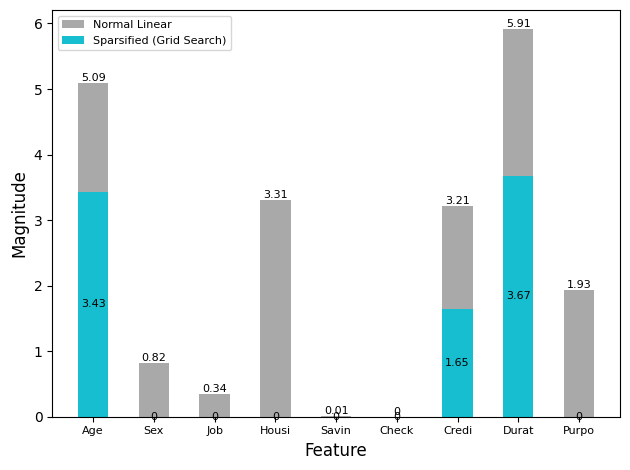

In [ ]:
fig, ax = plot_weight(norm_coef, sparse_coef, cols)

In [ ]:
def show_change_weights(explainer, **kwargs):
    verbose = kwargs["verbose"] if "verbose" in kwargs else False
    
    norm_coef, sparse_coef = find_weight(explainer, verbose=verbose)
    fig, ax = plot_weight(norm_coef, sparse_coef, cols)
    
    return fig, ax

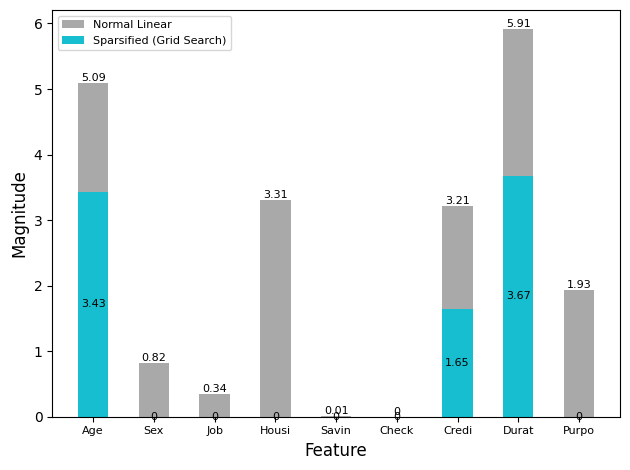

In [ ]:
fig, ax = show_change_weights(explainer)